# __Training and tuning neural network__
- Dataset: Guarujá Municipality - São Paulo - Brazil
- Part 2/3

## Authorship:
        Caio Azevedo
        São Paulo University, October, 2023

## Main goals:


__Objetivos__:

- Tratamento dos dados para aplicação da rede neural: 
   - remoção de features irrelevantes;
   - normalização do dataset;
   - separação do dados de treino e teste da rede neural

- Treinamento e avaliação das redes neurais:
   - implementação keras
   - implementação customizada

- Automação do setup dos hiperparâmetros para melhor desempenho (critério inicial acurácia).
  - em __15-08-2021__ - Uso Keras Tuning para otimização dos hyperparameters Keras (vide arquivo .ipynb)
  - em __29-08-2021__ - Força Bruta para otimização dos hiperparametros na rede customizada

- Avaliar performance da rede com e sem 'features irrelevantes'.

__Sobre a implementação da Rede Neural Proprietária__:

1. ref. https://whimsical.com/artificial-neural-network-4cTMNjQBkkCwJHZhUy7BTV


Comparando predição com rede do keras
- ref. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Tunning neural netowrks
- ref. http://karpathy.github.io/2019/04/25/recipe/

Sobre as métricas
- ref. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

## Coding

### Imported libraries

In [1]:
import datetime
start = datetime.datetime.now()

In [1]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

### Auxiliary functions

In [4]:
#gráfico que relacionada cada uma das features com o valor predito
def plotSwarmChart(dataSet):
    dataSet['Constante'] = 0 #feature inútil para referência do gráfico

    f, axes = plt.subplots(1, 7, figsize=(35, 17), sharex=False)
    f.subplots_adjust(hspace=0.2, wspace=0.7)
    
    sns.catplot(x=dataSet.columns[6], y='score', kind="swarm", hue='score', data=dataSet,ax=axes[6])
    
    for i in range(7):
        col = dataSet.columns[i] 
        ax = sns.swarmplot(x=dataSet['Constante'],y=dataSet[col].values,hue=(dataSet['score']>0.5),ax=axes[i])
        ax.set_title(col)
        
    plt.close(2)
    plt.close(3)
    plt.show()

In [5]:
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [6]:
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('Área curva ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='aleatório', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='RNA', color='blue')
    
    # axis labels
    pyplot.xlabel('Taxa de falso positivo')
    pyplot.ylabel('Taxa de verdadeiro positivo')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [7]:
#divide o dataset em base de treino e teste
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training and testing sets
    seed = 7
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(X_train)
    # scale the training dataset
    X_train = scaler.transform(X_train)
    
    # scale the test dataset
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [8]:
#divide o dataset em treino-teste-validação
def dataPreparation2(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

### Obtaining and visualize the dataset

In [9]:
APP_PATH = os.getcwd()

#file = "Input_Guaruja_50m_shuffled.csv"
#file = "Input_Guaruja_100m_shuffled.csv"
#file = "Input_Guaruja_150m_shuffled.csv"
#file = "Input_Guaruja_200m_shuffled.csv"

#file = "pt_nocorrencias_1km_shuffled.csv"
#file = "pt_nocorrencias_2km_shuffled.csv"
#file = "pt_nocorrencias_3km_shuffled.csv"
#file = "pt_nocorrencias_4km_shuffled.csv"

file = "guaruja_shuffled.csv"


dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 

# load the dataset
#dataset = dataset.sample(frac = 1) #embaralha os registros
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0


In [10]:
dataset.shape

(200, 11)

In [11]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.0
mean,100.50,375351.60,7350229.58,14.42,0.03,23.94,64.32,209.79,32.56,75.80,0.5
std,57.88,4313.00,4368.70,13.62,0.41,11.79,56.08,103.92,31.56,26.72,0.5
min,1.00,365857.79,7341789.72,0.09,-0.59,0.09,0.23,0.04,2.00,20.00,0.0
25%,50.75,372179.26,7346972.48,4.29,-0.01,18.08,14.33,121.04,2.00,90.00,0.0
50%,100.50,375219.03,7349677.08,6.13,-0.00,25.33,54.48,202.74,2.00,90.00,0.0
75%,150.25,379116.73,7354032.25,26.33,0.00,30.77,94.71,316.40,65.00,90.00,1.0
max,200.00,383738.84,7359892.24,69.73,4.30,69.73,226.06,359.51,65.00,90.00,1.0


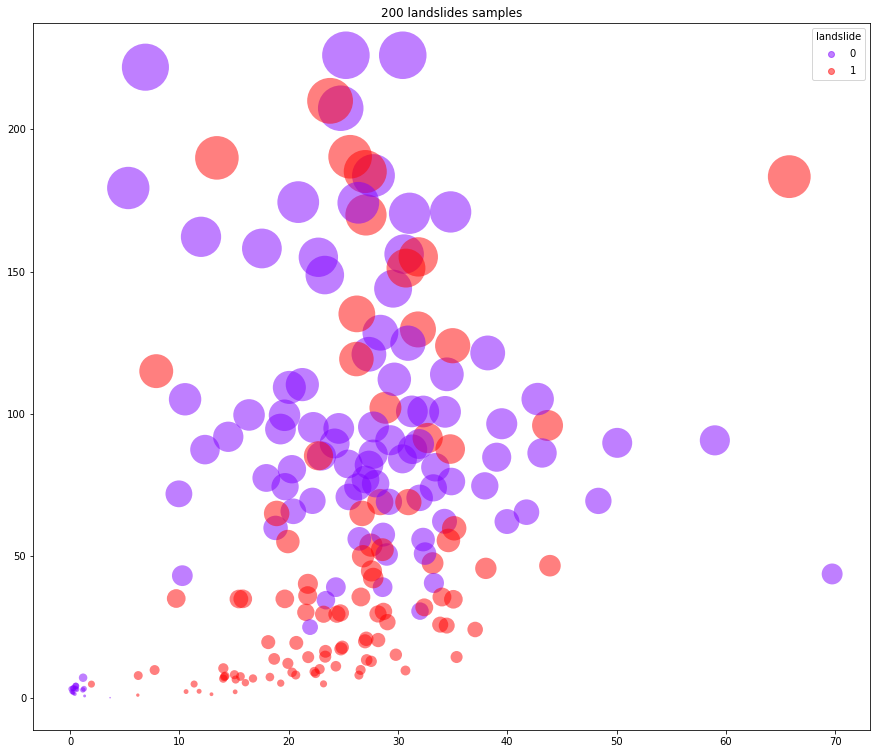

In [12]:
fig, ax = plt.subplots(figsize=(15,13))
sizes = dataset['elevation']*10
scatter = ax.scatter(dataset['slope'], dataset['elevation'], 
           c=(dataset['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

ax.title.set_text("{}{}".format(len(dataset.index), ' landslides samples')) 

plt.show()

### DataPrep
 - Based on the results of the feature importance analysis, all features were retained for training the ANN.
 - We addressed concerns about data leakage.

In [13]:
#features menos relevantes guaruja
#dataset = dataset.drop('elevation',axis=1)
#dataset = dataset.drop('curv',axis=1)
#dataset = dataset.drop('lito',axis=1)
#dataset = dataset.drop('uso_solo',axis=1)
# de fato, essas 3 features são irrelevantes pois a acurácia é similar sem elas no dataset
dataset = dataset[['slope','aspect','elevation','land_use','lithology','twi','curvature','class']]
dataset.head(5)

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0


In [14]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation2(dataset)
#X_train, X_test, y_train, y_test = dataPreparation(dataset)

In [15]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [16]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [ 1.63025317  0.948116    1.03804377  1.          1.          1.35762042
 -0.98499636]


In [17]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [18]:
X.shape

(200, 7)

In [19]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [20]:
y.shape

(200, 1)

In [21]:
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


__Computa o número de variáveis de entrada (features) e saída (sempre 1)__

In [22]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

### Custom neural network training

#### Hyperparameters tunning
- Brute force method
- custom classes and functions

In [23]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [24]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [25]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #input layer
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

    #output layer
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [26]:
# (batch_size) implementa o mini-batch que acelera o tempo de treinamento, requer método de inicialização do mini-batch. 
#ideal que o batch_size seja multiplo do tamanho do conjunto de dados de treinamento, que aqui é de 128 
neurons = [7,8,12] 
# preciso encontrar uma forma de implementar a alteração do numero de neuronios na camada oculta variando 
# de n-2 até n+6
hidden_layers = [1,2,3]
learning_rate = [0.001,0.005,0.01]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [27]:
def setTestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    #nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.25, patience=50) 

    #camada de entrada
    print('\033[1m Input layer: {} inputs neurons  {} outputs neurons {} learning rate \033[0m'.format(input_dim, neurons,num_learning_rate))
    #nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        print(' hidden layer {} neurons {} layers '.format(neurons,hidden_layers))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal))
    
    #nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  
    print('\033[1m {} last hidden layer neurons, {} output neurons \033[0m'.format(neurons,output_dim))

In [28]:
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    setTestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)

 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.005 learning rate 
 hidden lay

In [29]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('To {} neurons, {} layer(s),  {} learning rate, {} batch size, {} dropout rate, we have: \033[1m Accuracy: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 0.67619992 + 0.00000000 = 0.67619992 loss_val = 0.67619992
epoch: 3000/40000 loss_train: 0.46178361 + 0.00000000 = 0.46178361 loss_val = 0.46178361
epoch: 6000/40000 loss_train: 0.32434024 + 0.00000000 = 0.32434024 loss_val = 0.32434024
epoch: 9000/40000 loss_train: 0.22133513 + 0.00000000 = 0.22133513 loss_val = 0.22133513
epoch: 12000/40000 loss_train: 0.16247143 + 0.00000000 = 0.16247143 loss_val = 0.16247143
epoch: 15000/40000 loss_train: 0.13162682 + 0.00000000 = 0.13162682 loss_val = 0.13162682
epoch: 18000/40000 loss_train: 0.11362833 + 0.00000000 = 0.11362833 loss_val = 0.11362833
epoch: 21000/40000 loss_train: 0.10339865 + 0.00000000 = 0.10339865 loss_val = 0.10339865
epoch: 24000/40000 loss_train: 0.09642908 + 0.00000000 = 0.09642908 loss_val = 0.09642908
epoch: 27000/40000 loss_train: 0.09116778 + 0.00000000 = 0.09116778 loss_val = 0.09116778
epoch: 30000/40000 loss_train: 0.08699330 + 0.00000000 = 0.08699330 loss_val = 0.08699330
epoch: 33000/4

epoch: 3000/40000 loss_train: 0.27117657 + 0.00000000 = 0.27117657 loss_val = 0.27117657
epoch: 6000/40000 loss_train: 0.08470084 + 0.00000000 = 0.08470084 loss_val = 0.08470084
epoch: 9000/40000 loss_train: 0.05861869 + 0.00000000 = 0.05861869 loss_val = 0.05861869
epoch: 12000/40000 loss_train: 0.04658969 + 0.00000000 = 0.04658969 loss_val = 0.04658969
epoch: 15000/40000 loss_train: 0.03873062 + 0.00000000 = 0.03873062 loss_val = 0.03873062
epoch: 18000/40000 loss_train: 0.03278346 + 0.00000000 = 0.03278346 loss_val = 0.03278346
epoch: 21000/40000 loss_train: 0.02788164 + 0.00000000 = 0.02788164 loss_val = 0.02788164
epoch: 24000/40000 loss_train: 0.02372711 + 0.00000000 = 0.02372711 loss_val = 0.02372711
epoch: 27000/40000 loss_train: 0.02019533 + 0.00000000 = 0.02019533 loss_val = 0.02019533
epoch: 30000/40000 loss_train: 0.01719123 + 0.00000000 = 0.01719123 loss_val = 0.01719123
epoch: 33000/40000 loss_train: 0.01467110 + 0.00000000 = 0.01467110 loss_val = 0.01467110
epoch: 36000/

epoch: 39000/40000 loss_train: 0.01469435 + 0.00000000 = 0.01469435 loss_val = 0.01469435
To 7 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.73181425 + 0.00000000 = 0.73181425 loss_val = 0.73181425
epoch: 3000/40000 loss_train: 0.08406882 + 0.00000000 = 0.08406882 loss_val = 0.08406882
epoch: 6000/40000 loss_train: 0.05921352 + 0.00000000 = 0.05921352 loss_val = 0.05921352
epoch: 9000/40000 loss_train: 0.04763256 + 0.00000000 = 0.04763256 loss_val = 0.04763256
epoch: 12000/40000 loss_train: 0.03942178 + 0.00000000 = 0.03942178 loss_val = 0.03942178
To 7 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 95.24% 
epoch:    0/40000 loss_train: 0.88095921 + 0.00000000 = 0.88095921 loss_val = 0.88095921
epoch: 3000/40000 loss_train: 0.09713262 + 0.00000000 = 0.09713262 loss_val = 0.09713262
epoch: 6000/40000 loss_train: 0.07127834 + 0.00000000 = 0.07127834 loss_v

epoch: 18000/40000 loss_train: 0.08641311 + 0.00000000 = 0.08641311 loss_val = 0.08641311
epoch: 21000/40000 loss_train: 0.07576044 + 0.00000000 = 0.07576044 loss_val = 0.07576044
epoch: 24000/40000 loss_train: 0.06769360 + 0.00000000 = 0.06769360 loss_val = 0.06769360
epoch: 27000/40000 loss_train: 0.06148756 + 0.00000000 = 0.06148756 loss_val = 0.06148756
epoch: 30000/40000 loss_train: 0.05652129 + 0.00000000 = 0.05652129 loss_val = 0.05652129
epoch: 33000/40000 loss_train: 0.05251601 + 0.00000000 = 0.05251601 loss_val = 0.05251601
epoch: 36000/40000 loss_train: 0.04922294 + 0.00000000 = 0.04922294 loss_val = 0.04922294
epoch: 39000/40000 loss_train: 0.04638712 + 0.00000000 = 0.04638712 loss_val = 0.04638712
To 8 neurons, 1 layer(s),  0.001 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.64304049 + 0.00000000 = 0.64304049 loss_val = 0.64304049
epoch: 3000/40000 loss_train: 0.39207269 + 0.00000000 = 0.39207269 loss_val = 0.39207

To 8 neurons, 1 layer(s),  0.005 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.72228006 + 0.00000000 = 0.72228006 loss_val = 0.72228006
epoch: 3000/40000 loss_train: 0.16685152 + 0.00000000 = 0.16685152 loss_val = 0.16685152
epoch: 6000/40000 loss_train: 0.08907761 + 0.00000000 = 0.08907761 loss_val = 0.08907761
epoch: 9000/40000 loss_train: 0.06693807 + 0.00000000 = 0.06693807 loss_val = 0.06693807
epoch: 12000/40000 loss_train: 0.05487453 + 0.00000000 = 0.05487453 loss_val = 0.05487453
epoch: 15000/40000 loss_train: 0.04675306 + 0.00000000 = 0.04675306 loss_val = 0.04675306
epoch: 18000/40000 loss_train: 0.04063491 + 0.00000000 = 0.04063491 loss_val = 0.04063491
epoch: 21000/40000 loss_train: 0.03481743 + 0.00000000 = 0.03481743 loss_val = 0.03481743
epoch: 24000/40000 loss_train: 0.03028541 + 0.00000000 = 0.03028541 loss_val = 0.03028541
epoch: 27000/40000 loss_train: 0.02124929 + 0.00000000 = 0.02124929 loss_val = 0.021249

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 1 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.86011269 + 0.00000000 = 0.86011269 loss_val = 0.86011269
epoch: 3000/40000 loss_train: 0.09802829 + 0.00000000 = 0.09802829 loss_val = 0.09802829
epoch: 6000/40000 loss_train: 0.03357002 + 0.00000000 = 0.03357002 loss_val = 0.03357002
epoch: 9000/40000 loss_train: 0.01840643 + 0.00000000 = 0.01840643 loss_val = 0.01840643
To 8 neurons, 1 layer(s),  0.01 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.80747864 + 0.00000000 = 0.80747864 loss_val = 0.80747864
epoch: 3000/40000 loss_train: 0.56856181 + 0.00000000 = 0.56856181 loss_val = 0.56856181
epoch: 6000/40000 loss_train: 0.42762600 + 0.00000000 = 0.42762600 loss_val = 0.42762600
epoch: 9000/40000 loss_train: 0.29490488 + 0.00000000 = 0.29490488 loss_val = 0.29490488
epoch: 12000/40000 loss_train: 0.19730468 + 0.00000000 = 0.19730468 loss_va

epoch: 27000/40000 loss_train: 0.05652546 + 0.00000000 = 0.05652546 loss_val = 0.05652546
epoch: 30000/40000 loss_train: 0.05115181 + 0.00000000 = 0.05115181 loss_val = 0.05115181
epoch: 33000/40000 loss_train: 0.04680550 + 0.00000000 = 0.04680550 loss_val = 0.04680550
epoch: 36000/40000 loss_train: 0.04314108 + 0.00000000 = 0.04314108 loss_val = 0.04314108
epoch: 39000/40000 loss_train: 0.03988112 + 0.00000000 = 0.03988112 loss_val = 0.03988112
To 12 neurons, 1 layer(s),  0.001 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.92018563 + 0.00000000 = 0.92018563 loss_val = 0.92018563
epoch: 3000/40000 loss_train: 0.11229153 + 0.00000000 = 0.11229153 loss_val = 0.11229153
epoch: 6000/40000 loss_train: 0.07329672 + 0.00000000 = 0.07329672 loss_val = 0.07329672
epoch: 9000/40000 loss_train: 0.05947650 + 0.00000000 = 0.05947650 loss_val = 0.05947650
epoch: 12000/40000 loss_train: 0.04945514 + 0.00000000 = 0.04945514 loss_val = 0.049

epoch: 24000/40000 loss_train: 0.01856766 + 0.00000000 = 0.01856766 loss_val = 0.01856766
epoch: 27000/40000 loss_train: 0.01301567 + 0.00000000 = 0.01301567 loss_val = 0.01301567
epoch: 30000/40000 loss_train: 0.00914039 + 0.00000000 = 0.00914039 loss_val = 0.00914039
epoch: 33000/40000 loss_train: 0.00669478 + 0.00000000 = 0.00669478 loss_val = 0.00669478


C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.78726289 + 0.00000000 = 0.78726289 loss_val = 0.78726289
epoch: 3000/40000 loss_train: 0.07113156 + 0.00000000 = 0.07113156 loss_val = 0.07113156
epoch: 6000/40000 loss_train: 0.04172998 + 0.00000000 = 0.04172998 loss_val = 0.04172998
epoch: 9000/40000 loss_train: 0.03031750 + 0.00000000 = 0.03031750 loss_val = 0.03031750
epoch: 12000/40000 loss_train: 0.02351772 + 0.00000000 = 0.02351772 loss_val = 0.02351772
epoch: 15000/40000 loss_train: 0.01812317 + 0.00000000 = 0.01812317 loss_val = 0.01812317
epoch: 18000/40000 loss_train: 0.01380550 + 0.00000000 = 0.01380550 loss_val = 0.01380550
epoch: 21000/40000 loss_train: 0.01057390 + 0.00000000 = 0.01057390 loss_val = 0.01057390
To 12 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 1.31027130 + 0.00000000 = 1.31027130 los

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 1 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 1.35428282 + 0.00000000 = 1.35428282 loss_val = 1.35428282
epoch: 3000/40000 loss_train: 0.07559585 + 0.00000000 = 0.07559585 loss_val = 0.07559585
epoch: 6000/40000 loss_train: 0.04797728 + 0.00000000 = 0.04797728 loss_val = 0.04797728
epoch: 9000/40000 loss_train: 0.03046426 + 0.00000000 = 0.03046426 loss_val = 0.03046426
epoch: 12000/40000 loss_train: 0.02009619 + 0.00000000 = 0.02009619 loss_val = 0.02009619
epoch: 15000/40000 loss_train: 0.01433837 + 0.00000000 = 0.01433837 loss_val = 0.01433837
epoch: 18000/40000 loss_train: 0.01052371 + 0.00000000 = 0.01052371 loss_val = 0.01052371
epoch: 21000/40000 loss_train: 0.00784161 + 0.00000000 = 0.00784161 loss_val = 0.00784161
epoch: 24000/40000 loss_train: 0.00601260 + 0.00000000 = 0.00601260 loss_val = 0.00601260
epoch: 27000/40000 loss_train: 0.00470830 + 0.00000000 = 0.00470830 loss_val = 0.0047083

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 1 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.78066563 + 0.00000000 = 0.78066563 loss_val = 0.78066563
epoch: 3000/40000 loss_train: 0.11230400 + 0.00000000 = 0.11230400 loss_val = 0.11230400
epoch: 6000/40000 loss_train: 0.03153027 + 0.00000000 = 0.03153027 loss_val = 0.03153027
epoch: 9000/40000 loss_train: 0.01916159 + 0.00000000 = 0.01916159 loss_val = 0.01916159
epoch: 12000/40000 loss_train: 0.01312440 + 0.00000000 = 0.01312440 loss_val = 0.01312440
epoch: 15000/40000 loss_train: 0.00949081 + 0.00000000 = 0.00949081 loss_val = 0.00949081
epoch: 18000/40000 loss_train: 0.00715001 + 0.00000000 = 0.00715001 loss_val = 0.00715001
epoch: 21000/40000 loss_train: 0.00556481 + 0.00000000 = 0.00556481 loss_val = 0.00556481
epoch: 24000/40000 loss_train: 0.00442609 + 0.00000000 = 0.00442609 loss_val = 0.00442609
epoch: 27000/40000 loss_train: 0.00361430 + 0.00000000 = 0.00361430 loss_val = 0.00361

epoch: 36000/40000 loss_train: 0.04038590 + 0.00000000 = 0.04038590 loss_val = 0.04038590
epoch: 39000/40000 loss_train: 0.03788244 + 0.00000000 = 0.03788244 loss_val = 0.03788244
To 7 neurons, 2 layer(s),  0.001 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.89036338 + 0.00000000 = 0.89036338 loss_val = 0.89036338
epoch: 3000/40000 loss_train: 0.57316238 + 0.00000000 = 0.57316238 loss_val = 0.57316238
epoch: 6000/40000 loss_train: 0.43851730 + 0.00000000 = 0.43851730 loss_val = 0.43851730
epoch: 9000/40000 loss_train: 0.32911538 + 0.00000000 = 0.32911538 loss_val = 0.32911538
epoch: 12000/40000 loss_train: 0.27244453 + 0.00000000 = 0.27244453 loss_val = 0.27244453
epoch: 15000/40000 loss_train: 0.24387777 + 0.00000000 = 0.24387777 loss_val = 0.24387777
epoch: 18000/40000 loss_train: 0.22807695 + 0.00000000 = 0.22807695 loss_val = 0.22807695
epoch: 21000/40000 loss_train: 0.21830686 + 0.00000000 = 0.21830686 loss_val = 0.2183068

epoch: 36000/40000 loss_train: 0.00046089 + 0.00000000 = 0.00046089 loss_val = 0.00046089
epoch: 39000/40000 loss_train: 0.00040422 + 0.00000000 = 0.00040422 loss_val = 0.00040422
To 7 neurons, 2 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.84163173 + 0.00000000 = 0.84163173 loss_val = 0.84163173
epoch: 3000/40000 loss_train: 0.09429641 + 0.00000000 = 0.09429641 loss_val = 0.09429641
epoch: 6000/40000 loss_train: 0.02602407 + 0.00000000 = 0.02602407 loss_val = 0.02602407
To 7 neurons, 2 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.75258347 + 0.00000000 = 0.75258347 loss_val = 0.75258347
epoch: 3000/40000 loss_train: 0.05746394 + 0.00000000 = 0.05746394 loss_val = 0.05746394
epoch: 6000/40000 loss_train: 0.02783673 + 0.00000000 = 0.02783673 loss_val = 0.02783673
epoch: 9000/40000 loss_train: 0.01247264 + 0.00000000 = 0.01247264 loss_va

epoch: 3000/40000 loss_train: 0.59536711 + 0.00000000 = 0.59536711 loss_val = 0.59536711
epoch: 6000/40000 loss_train: 0.41892345 + 0.00000000 = 0.41892345 loss_val = 0.41892345
epoch: 9000/40000 loss_train: 0.25646392 + 0.00000000 = 0.25646392 loss_val = 0.25646392
epoch: 12000/40000 loss_train: 0.16246693 + 0.00000000 = 0.16246693 loss_val = 0.16246693
epoch: 15000/40000 loss_train: 0.11347508 + 0.00000000 = 0.11347508 loss_val = 0.11347508
epoch: 18000/40000 loss_train: 0.09054088 + 0.00000000 = 0.09054088 loss_val = 0.09054088
epoch: 21000/40000 loss_train: 0.07758962 + 0.00000000 = 0.07758962 loss_val = 0.07758962
epoch: 24000/40000 loss_train: 0.06897372 + 0.00000000 = 0.06897372 loss_val = 0.06897372
epoch: 27000/40000 loss_train: 0.06268511 + 0.00000000 = 0.06268511 loss_val = 0.06268511
epoch: 30000/40000 loss_train: 0.05768292 + 0.00000000 = 0.05768292 loss_val = 0.05768292
To 8 neurons, 2 layer(s),  0.001 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 97.

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 2 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 1.06109304 + 0.00000000 = 1.06109304 loss_val = 1.06109304
epoch: 3000/40000 loss_train: 0.24476218 + 0.00000000 = 0.24476218 loss_val = 0.24476218
epoch: 6000/40000 loss_train: 0.14807756 + 0.00000000 = 0.14807756 loss_val = 0.14807756
epoch: 9000/40000 loss_train: 0.04813841 + 0.00000000 = 0.04813841 loss_val = 0.04813841
To 8 neurons, 2 layer(s),  0.005 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.74243644 + 0.00000000 = 0.74243644 loss_val = 0.74243644
epoch: 3000/40000 loss_train: 0.21883084 + 0.00000000 = 0.21883084 loss_val = 0.21883084
epoch: 6000/40000 loss_train: 0.04330172 + 0.00000000 = 0.04330172 loss_val = 0.04330172
epoch: 9000/40000 loss_train: 0.02033384 + 0.00000000 = 0.02033384 loss_val = 0.02033384
epoch: 12000/40000 loss_train: 0.01268967 + 0.00000000 = 0.01268967 loss_

epoch: 15000/40000 loss_train: 0.00232969 + 0.00000000 = 0.00232969 loss_val = 0.00232969
epoch: 18000/40000 loss_train: 0.00160284 + 0.00000000 = 0.00160284 loss_val = 0.00160284
epoch: 21000/40000 loss_train: 0.00118844 + 0.00000000 = 0.00118844 loss_val = 0.00118844
epoch: 24000/40000 loss_train: 0.00092689 + 0.00000000 = 0.00092689 loss_val = 0.00092689
epoch: 27000/40000 loss_train: 0.00074984 + 0.00000000 = 0.00074984 loss_val = 0.00074984
epoch: 30000/40000 loss_train: 0.00062381 + 0.00000000 = 0.00062381 loss_val = 0.00062381
epoch: 33000/40000 loss_train: 0.00052983 + 0.00000000 = 0.00052983 loss_val = 0.00052983
epoch: 36000/40000 loss_train: 0.00045804 + 0.00000000 = 0.00045804 loss_val = 0.00045804
epoch: 39000/40000 loss_train: 0.00040166 + 0.00000000 = 0.00040166 loss_val = 0.00040166
To 8 neurons, 2 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.78930895 + 0.00000000 = 0.78930895 loss_val = 0.7893

epoch: 18000/40000 loss_train: 0.16703910 + 0.00000000 = 0.16703910 loss_val = 0.16703910
epoch: 21000/40000 loss_train: 0.13642250 + 0.00000000 = 0.13642250 loss_val = 0.13642250
epoch: 24000/40000 loss_train: 0.10987869 + 0.00000000 = 0.10987869 loss_val = 0.10987869
epoch: 27000/40000 loss_train: 0.08570807 + 0.00000000 = 0.08570807 loss_val = 0.08570807
epoch: 30000/40000 loss_train: 0.06708228 + 0.00000000 = 0.06708228 loss_val = 0.06708228
epoch: 33000/40000 loss_train: 0.05363456 + 0.00000000 = 0.05363456 loss_val = 0.05363456
epoch: 36000/40000 loss_train: 0.04039408 + 0.00000000 = 0.04039408 loss_val = 0.04039408
epoch: 39000/40000 loss_train: 0.02773892 + 0.00000000 = 0.02773892 loss_val = 0.02773892
To 12 neurons, 2 layer(s),  0.001 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.92185948 + 0.00000000 = 0.92185948 loss_val = 0.92185948
epoch: 3000/40000 loss_train: 0.21385447 + 0.00000000 = 0.21385447 loss_val = 0.2

epoch: 6000/40000 loss_train: 0.05780076 + 0.00000000 = 0.05780076 loss_val = 0.05780076
epoch: 9000/40000 loss_train: 0.05429129 + 0.00000000 = 0.05429129 loss_val = 0.05429129
epoch: 12000/40000 loss_train: 0.05027866 + 0.00000000 = 0.05027866 loss_val = 0.05027866
epoch: 15000/40000 loss_train: 0.04427417 + 0.00000000 = 0.04427417 loss_val = 0.04427417
epoch: 18000/40000 loss_train: 0.03400902 + 0.00000000 = 0.03400902 loss_val = 0.03400902
epoch: 21000/40000 loss_train: 0.01896517 + 0.00000000 = 0.01896517 loss_val = 0.01896517
epoch: 24000/40000 loss_train: 0.00920736 + 0.00000000 = 0.00920736 loss_val = 0.00920736
epoch: 27000/40000 loss_train: 0.00550002 + 0.00000000 = 0.00550002 loss_val = 0.00550002
epoch: 30000/40000 loss_train: 0.00371712 + 0.00000000 = 0.00371712 loss_val = 0.00371712


C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.79720933 + 0.00000000 = 0.79720933 loss_val = 0.79720933
epoch: 3000/40000 loss_train: 0.09065736 + 0.00000000 = 0.09065736 loss_val = 0.09065736
epoch: 6000/40000 loss_train: 0.02154768 + 0.00000000 = 0.02154768 loss_val = 0.02154768
To 12 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.76828333 + 0.00000000 = 0.76828333 loss_val = 0.76828333
epoch: 3000/40000 loss_train: 0.07798740 + 0.00000000 = 0.07798740 loss_val = 0.07798740
epoch: 6000/40000 loss_train: 0.06522091 + 0.00000000 = 0.06522091 loss_val = 0.06522091
epoch: 9000/40000 loss_train: 0.05094181 + 0.00000000 = 0.05094181 loss_val = 0.05094181
epoch: 12000/40000 loss_train: 0.03160517 + 0.00000000 = 0.03160517 loss_val = 0.03160517
epoch: 15000/40000 loss_train: 0.01241352 + 0.00000000 = 0.01241352 loss_

epoch: 24000/40000 loss_train: 0.21747880 + 0.00000000 = 0.21747880 loss_val = 0.21747880
epoch: 27000/40000 loss_train: 0.21374086 + 0.00000000 = 0.21374086 loss_val = 0.21374086
epoch: 30000/40000 loss_train: 0.21116413 + 0.00000000 = 0.21116413 loss_val = 0.21116413
epoch: 33000/40000 loss_train: 0.20917745 + 0.00000000 = 0.20917745 loss_val = 0.20917745
epoch: 36000/40000 loss_train: 0.20699540 + 0.00000000 = 0.20699540 loss_val = 0.20699540
epoch: 39000/40000 loss_train: 0.20550968 + 0.00000000 = 0.20550968 loss_val = 0.20550968
To 7 neurons, 3 layer(s),  0.001 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 88.10% 
epoch:    0/40000 loss_train: 1.14791880 + 0.00000000 = 1.14791880 loss_val = 1.14791880
epoch: 3000/40000 loss_train: 0.52917076 + 0.00000000 = 0.52917076 loss_val = 0.52917076
epoch: 6000/40000 loss_train: 0.36548024 + 0.00000000 = 0.36548024 loss_val = 0.36548024
epoch: 9000/40000 loss_train: 0.22021565 + 0.00000000 = 0.22021565 loss_val = 0.2202156

To 7 neurons, 3 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 90.48% 
epoch:    0/40000 loss_train: 0.72361437 + 0.00000000 = 0.72361437 loss_val = 0.72361437
epoch: 3000/40000 loss_train: 0.04469117 + 0.00000000 = 0.04469117 loss_val = 0.04469117
epoch: 6000/40000 loss_train: 0.01118338 + 0.00000000 = 0.01118338 loss_val = 0.01118338
epoch: 9000/40000 loss_train: 0.00360845 + 0.00000000 = 0.00360845 loss_val = 0.00360845
epoch: 12000/40000 loss_train: 0.00185929 + 0.00000000 = 0.00185929 loss_val = 0.00185929
epoch: 15000/40000 loss_train: 0.00117062 + 0.00000000 = 0.00117062 loss_val = 0.00117062
epoch: 18000/40000 loss_train: 0.00081955 + 0.00000000 = 0.00081955 loss_val = 0.00081955
epoch: 21000/40000 loss_train: 0.00061519 + 0.00000000 = 0.00061519 loss_val = 0.00061519
epoch: 24000/40000 loss_train: 0.00048675 + 0.00000000 = 0.00048675 loss_val = 0.00048675
epoch: 27000/40000 loss_train: 0.00040106 + 0.00000000 = 0.00040106 loss_val = 0.000401

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 3 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.73169231 + 0.00000000 = 0.73169231 loss_val = 0.73169231
epoch: 3000/40000 loss_train: 0.21922969 + 0.00000000 = 0.21922969 loss_val = 0.21922969
To 7 neurons, 3 layer(s),  0.01 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 88.10% 
epoch:    0/40000 loss_train: 1.08161143 + 0.00000000 = 1.08161143 loss_val = 1.08161143
epoch: 3000/40000 loss_train: 0.71123634 + 0.00000000 = 0.71123634 loss_val = 0.71123634
epoch: 6000/40000 loss_train: 0.69278651 + 0.00000000 = 0.69278651 loss_val = 0.69278651
epoch: 9000/40000 loss_train: 0.68740713 + 0.00000000 = 0.68740713 loss_val = 0.68740713
epoch: 12000/40000 loss_train: 0.67706878 + 0.00000000 = 0.67706878 loss_val = 0.67706878
epoch: 15000/40000 loss_train: 0.65330860 + 0.00000000 = 0.65330860 loss_val = 0.65330860
epoch: 18000/40000 loss_train: 0.56529955 + 0.00000000 = 0.56529955 loss_v

epoch: 39000/40000 loss_train: 0.00078735 + 0.00000000 = 0.00078735 loss_val = 0.00078735
To 8 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.75105412 + 0.00000000 = 0.75105412 loss_val = 0.75105412
epoch: 3000/40000 loss_train: 0.27351206 + 0.00000000 = 0.27351206 loss_val = 0.27351206
epoch: 6000/40000 loss_train: 0.19116934 + 0.00000000 = 0.19116934 loss_val = 0.19116934
epoch: 9000/40000 loss_train: 0.06719112 + 0.00000000 = 0.06719112 loss_val = 0.06719112
epoch: 12000/40000 loss_train: 0.02684901 + 0.00000000 = 0.02684901 loss_val = 0.02684901
To 8 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.75629715 + 0.00000000 = 0.75629715 loss_val = 0.75629715
epoch: 3000/40000 loss_train: 0.24472819 + 0.00000000 = 0.24472819 loss_val = 0.24472819
epoch: 6000/40000 loss_train: 0.06394126 + 0.00000000 = 0.06394126 loss

epoch: 12000/40000 loss_train: 0.00230117 + 0.00000000 = 0.00230117 loss_val = 0.00230117
epoch: 15000/40000 loss_train: 0.00128543 + 0.00000000 = 0.00128543 loss_val = 0.00128543
epoch: 18000/40000 loss_train: 0.00083012 + 0.00000000 = 0.00083012 loss_val = 0.00083012
epoch: 21000/40000 loss_train: 0.00058886 + 0.00000000 = 0.00058886 loss_val = 0.00058886
epoch: 24000/40000 loss_train: 0.00044488 + 0.00000000 = 0.00044488 loss_val = 0.00044488
epoch: 27000/40000 loss_train: 0.00035157 + 0.00000000 = 0.00035157 loss_val = 0.00035157
epoch: 30000/40000 loss_train: 0.00028725 + 0.00000000 = 0.00028725 loss_val = 0.00028725
epoch: 33000/40000 loss_train: 0.00024086 + 0.00000000 = 0.00024086 loss_val = 0.00024086
epoch: 36000/40000 loss_train: 0.00020593 + 0.00000000 = 0.00020593 loss_val = 0.00020593
epoch: 39000/40000 loss_train: 0.00017911 + 0.00000000 = 0.00017911 loss_val = 0.00017911
To 8 neurons, 3 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 100

epoch: 24000/40000 loss_train: 0.00145733 + 0.00000000 = 0.00145733 loss_val = 0.00145733
epoch: 27000/40000 loss_train: 0.00110792 + 0.00000000 = 0.00110792 loss_val = 0.00110792
epoch: 30000/40000 loss_train: 0.00087912 + 0.00000000 = 0.00087912 loss_val = 0.00087912
epoch: 33000/40000 loss_train: 0.00072032 + 0.00000000 = 0.00072032 loss_val = 0.00072032
epoch: 36000/40000 loss_train: 0.00060470 + 0.00000000 = 0.00060470 loss_val = 0.00060470
epoch: 39000/40000 loss_train: 0.00051760 + 0.00000000 = 0.00051760 loss_val = 0.00051760
To 12 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 1.75504709 + 0.00000000 = 1.75504709 loss_val = 1.75504709
epoch: 3000/40000 loss_train: 0.06802911 + 0.00000000 = 0.06802911 loss_val = 0.06802911
To 12 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.67385461 + 0.00000000 = 0.6738546

epoch: 15000/40000 loss_train: 0.00077401 + 0.00000000 = 0.00077401 loss_val = 0.00077401
epoch: 18000/40000 loss_train: 0.00055263 + 0.00000000 = 0.00055263 loss_val = 0.00055263
epoch: 21000/40000 loss_train: 0.00042174 + 0.00000000 = 0.00042174 loss_val = 0.00042174
epoch: 24000/40000 loss_train: 0.00033659 + 0.00000000 = 0.00033659 loss_val = 0.00033659
epoch: 27000/40000 loss_train: 0.00027743 + 0.00000000 = 0.00027743 loss_val = 0.00027743
epoch: 30000/40000 loss_train: 0.00023424 + 0.00000000 = 0.00023424 loss_val = 0.00023424
epoch: 33000/40000 loss_train: 0.00020156 + 0.00000000 = 0.00020156 loss_val = 0.00020156
epoch: 36000/40000 loss_train: 0.00017610 + 0.00000000 = 0.00017610 loss_val = 0.00017610
epoch: 39000/40000 loss_train: 0.00015577 + 0.00000000 = 0.00015577 loss_val = 0.00015577
To 12 neurons, 3 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.70344394 + 0.00000000 = 0.70344394 loss_val = 0.7034

In [30]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% was the best \033[1m accuracy\033[0m, having {} layers,{} neurons, {} of learning rate and {} of batch size as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

100.00% was the best  accuracy, having 1 layers,7 neurons, 0.001 of learning rate and 8 of batch size as hyperparameters!


In [31]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% was the best\033[1m accuracy\033[0m, with ANN {} '.format(best_ann.acuracia,best_ann.ann))

100.00% was the best accuracy, with ANN <Rede_Neural.NeuralNetwork object at 0x0000018038638100> 


In [32]:
lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
for best_hyper in lst_hyperP: 
  print('{:.2f}% was the best\033[1m accuracy\033[0m, having {} layers,{} neurons, {} of learning rate, {} of batch size and {} dropout rate as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

57.14% was the best accuracy, having 1 layers,8 neurons, 0.01 of learning rate, 8 of batch size and 0 dropout rate as hyperparameters!
57.14% was the best accuracy, having 1 layers,12 neurons, 0.01 of learning rate, 0 of batch size and 0 dropout rate as hyperparameters!
57.14% was the best accuracy, having 1 layers,12 neurons, 0.01 of learning rate, 4 of batch size and 0 dropout rate as hyperparameters!
57.14% was the best accuracy, having 1 layers,12 neurons, 0.01 of learning rate, 4 of batch size and 0.1 dropout rate as hyperparameters!
57.14% was the best accuracy, having 2 layers,8 neurons, 0.005 of learning rate, 0 of batch size and 0 dropout rate as hyperparameters!
57.14% was the best accuracy, having 2 layers,12 neurons, 0.01 of learning rate, 4 of batch size and 0 dropout rate as hyperparameters!
57.14% was the best accuracy, having 3 layers,7 neurons, 0.01 of learning rate, 8 of batch size and 0 dropout rate as hyperparameters!
83.33% was the best accuracy, having 2 layers,7 

In [33]:
lst_hyperP = []
lst_ANN = []

#for num_learning_rate in learning_rate:
#    for num_batch_size in batch_size:
#        nn = setBestNeuralNetwork2(num_learning_rate, input_dim, output_dim)

#        nn.fit(X_train, y_train, epochs=46000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

#        y_pred = nn.predict(X_val)
#        accu = 100*accuracy_score(y_val, y_pred > 0.5)
        #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
#        lst_hyperP.append( hyperparametros(accu,2,10,num_learning_rate,num_batch_size,0) )
#        lst_ANN.append(ANN_accuracy(accu,nn))
#        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

In [34]:
#best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
#best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [35]:
#best_ann2 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
#best_of_best_ANN.append(ANN_accuracy(best_ann2.acuracia,best_ann2.ann))
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann2.acuracia,best_ann2.ann))

In [36]:
#lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
#for best_hyper in lst_hyperP: 
#  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

In [37]:
#lst_hyperP = []
#lst_ANN = []

#for num_learning_rate in learning_rate:
#    for num_batch_size in batch_size:
#        nn = setBestNeuralNetwork3(num_learning_rate, input_dim, output_dim)

#        nn.fit(X_train, y_train, epochs=36000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

#        y_pred = nn.predict(X_val)
#        accu = 100*accuracy_score(y_val, y_pred > 0.5)
#        lst_hyperP.append( hyperparametros(accu,2,20,num_learning_rate,num_batch_size,0) )
#        lst_ANN.append(ANN_accuracy(accu,nn))
#        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

In [38]:
#best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
#best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [39]:
#best_ann3 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
#best_of_best_ANN.append(ANN_accuracy(best_ann3.acuracia,best_ann3.ann))
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann3.acuracia,best_ann3.ann))

In [40]:
#lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
#for best_hyper in lst_hyperP: 
#  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

#### Evaluation

https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb

In [41]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  accMedia = (accu + best_RNA.acuracia) / 2
  print('{:.2f}% accu_test - {:.2f}% foi a melhor\033[1m acurácia\033[0m, {:.2f} acc média {} RNA!'.format(accu,best_RNA.acuracia,accMedia,best_RNA.ann))
  accu = accMedia  
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))

98.33% accu_test - 100.00% foi a melhor acurácia, 99.17 acc média <Rede_Neural.NeuralNetwork object at 0x0000018038638100> RNA!


In [42]:
for best_hyper in best_of_best_hyper: 
  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

100.00% foi a melhor acurácia, obtida com 1 camadas,7 neurônios, 0.001 de learning rate, 8 de batch size e 0 dropout rate!


In [43]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [44]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

98.33%, acurácia de teste !


Segunda abordagem - configura uma nova rede com os parametros obtidos da otimização por força bruta

In [45]:
bestNN = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [46]:
bestHyper = max(best_of_best_hyper, key=lambda hyper: hyper.acuracia)
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(bestHyper.acuracia,bestHyper.camadas, bestHyper.learning_rate,bestHyper.batch_size,bestHyper.dropout))

100.00% foi a melhor acurácia, obtida com 1 camadas, 0.001 de learning rate, 8 de batch size e 0 dropout rate!


In [47]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

98.33%, acurácia de teste !


In [48]:
bstANN = bestNN
#bst_hyper = bstANN.hyper
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

100.00% foi a melhor acurácia, obtida com 1 camadas, 0.001 de learning rate, 8 de batch size e 0 dropout rate!


#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved.

In [49]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved!'.format(accu))
    bestNN.save('bestANN\suscetibilidadeNN_guaruja.pkl')
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

98.33%, excellent accuracy for test sample, ANN saved!


In [50]:
y_pred = bestNN.predict(X_train)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

Accuracy: 97.96%


In [51]:
y_pred = bestNN.predict(X_val)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

Accuracy: 100.00%


In [52]:
y_pred = bestNN.predict(X_test)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Accuracy: 98.33%


In [53]:
y_pred = bestNN.predict(X)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

Accuracy: 98.50%


__Quando obtermos uma boa acurácia com os dados de teste, salvamos a rede devidamente treinada__

In [54]:
yhat_probs = bestNN.predict(X_train)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_train, yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 97.96%


In [55]:
NetworkPerformance(y_train, yhat_probs)

Accuracy: 0.979592
Precision: 1.000000
Recall: 0.961538
F1 score: 0.980392
Cohens kappa: 0.959133
ROC AUC: 0.999582
[[46  0]
 [ 2 50]]


In [56]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 98.33%


In [57]:
NetworkPerformance(y_test, yhat_probs)

Accuracy: 0.983333
Precision: 1.000000
Recall: 0.965517
F1 score: 0.982456
Cohens kappa: 0.966592
ROC AUC: 0.985539
[[31  0]
 [ 1 28]]


In [58]:
yhat_probs = bestNN.predict(X_val)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_val,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 100.00%


In [59]:
NetworkPerformance(y_val, yhat_probs)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[24  0]
 [ 0 18]]


In [60]:
yhat_probs = bestNN.predict(X)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 98.50%


In [61]:
NetworkPerformance(y, yhat_probs)

Accuracy: 0.985000
Precision: 1.000000
Recall: 0.969697
F1 score: 0.984615
Cohens kappa: 0.969988
ROC AUC: 0.995900
[[101   0]
 [  3  96]]


Área curva ROC=0.9959


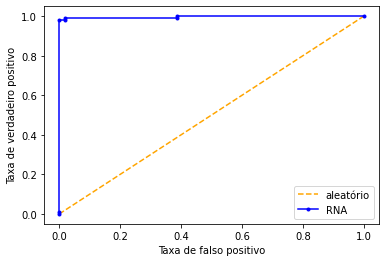

In [62]:
printAUROC(y,yhat_probs)

In [63]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y,(yhat_probs > 0.5))

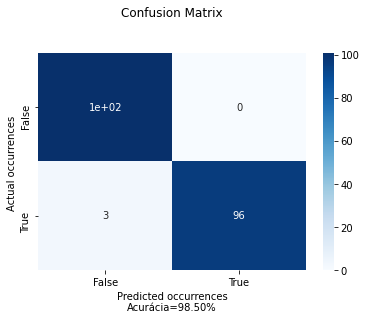

In [64]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('Predicted occurrences\nAcurácia={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Actual occurrences ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [65]:
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = yhat_probs

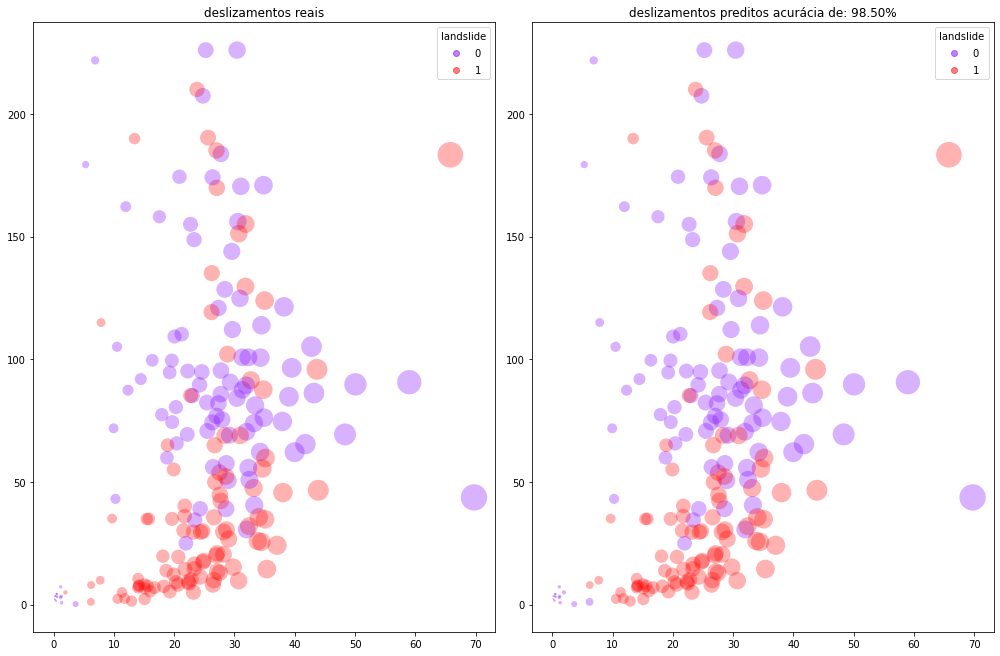

In [66]:
sizes = output_proprietario['slope']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

Agora considerar __RepeatedStratifiedKfold__ para avaliação da rede

ref. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

ref. https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

In [67]:
# Teste com objeto StratifiedKFold.
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [68]:
#X = dataset.drop('class',axis=1)
#y= dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#minmax = MinMaxScaler()
#X = minmax.fit_transform(X.astype(np.float64))
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


In [69]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits_stratified de X: ',rskf.get_n_splits(X, y),'\n')

# Prin_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

Numero de Splits_stratified de X:  10 

(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)


In [70]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [97.5, 100.0, 97.5, 100.0, 97.5, 100.0, 95.0, 100.0, 97.5, 100.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 95.0 %

Acurácia média: 98.5 %

Desvio Padrão: 1.7480147469502525


Recupera modelo otimizado saldo anteriormente e o testa com diferentes conjuntos de dados.

In [71]:
dataset

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0
...,...,...,...,...,...,...,...,...
195,65.807915,335.578705,183.386307,90,65,3.111852,0.009217,1
196,34.884327,335.742798,76.214539,90,2,34.884327,-0.003104,0
197,16.367725,167.967239,99.617256,90,2,16.367725,0.009234,0
198,30.434063,155.315613,226.055237,90,65,30.434063,0.000543,0


In [72]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred
output_proprietario.to_csv('bestANN/mapaSuscetibilidade_proprietaria.csv', encoding="utf-8")

Acurácia: 98.50%


In [73]:
NetworkPerformance(y, y_pred)

Accuracy: 0.985000
Precision: 1.000000
Recall: 0.969697
F1 score: 0.984615
Cohens kappa: 0.969988
ROC AUC: 0.995900
[[101   0]
 [  3  96]]


In [74]:
output_proprietario

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class,score
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0,0.000728
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1,0.994596
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0,0.001753
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1,0.997773
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0,0.151622
...,...,...,...,...,...,...,...,...,...,...,...,...
195,176,380247.0000,7355075.000,3.111852,0.009217,65.807915,183.386307,335.578705,65,90,1,0.945270
196,25,371328.0618,7346102.434,34.884327,-0.003104,34.884327,76.214539,335.742798,2,90,0,0.000130
197,47,375938.4356,7349522.181,16.367725,0.009234,16.367725,99.617256,167.967239,2,90,0,0.026370
198,87,379277.9602,7354447.102,30.434063,0.000543,30.434063,226.055237,155.315613,65,90,0,0.000470


ROC AUC=0.996


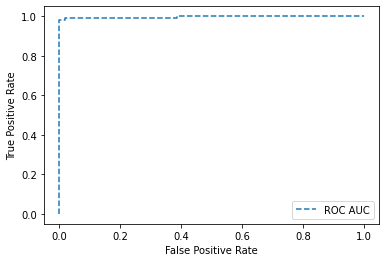

In [75]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- ref. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

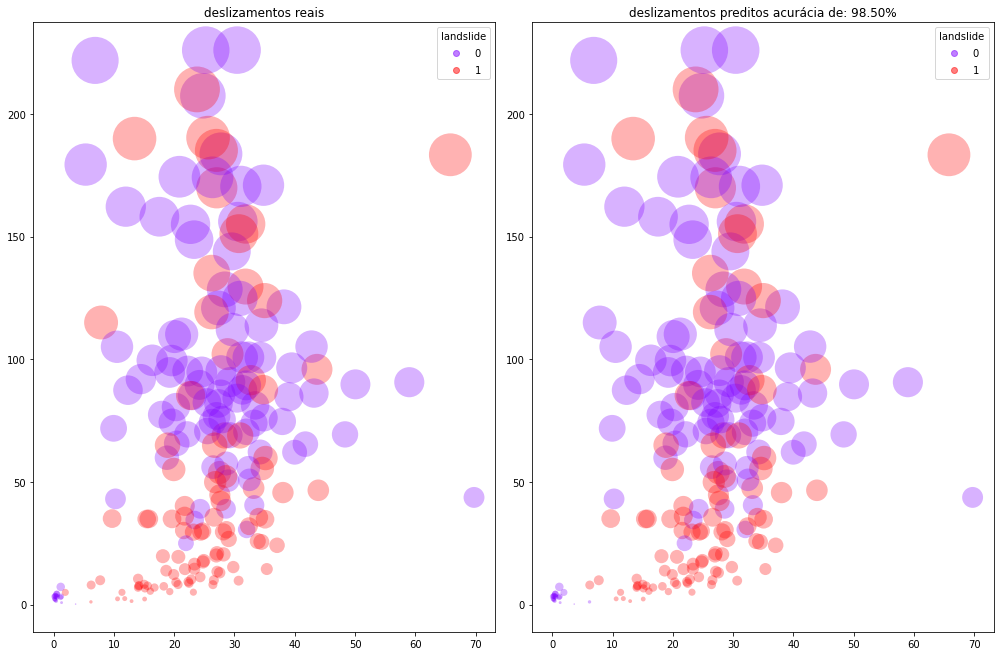

In [76]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)
C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 32.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


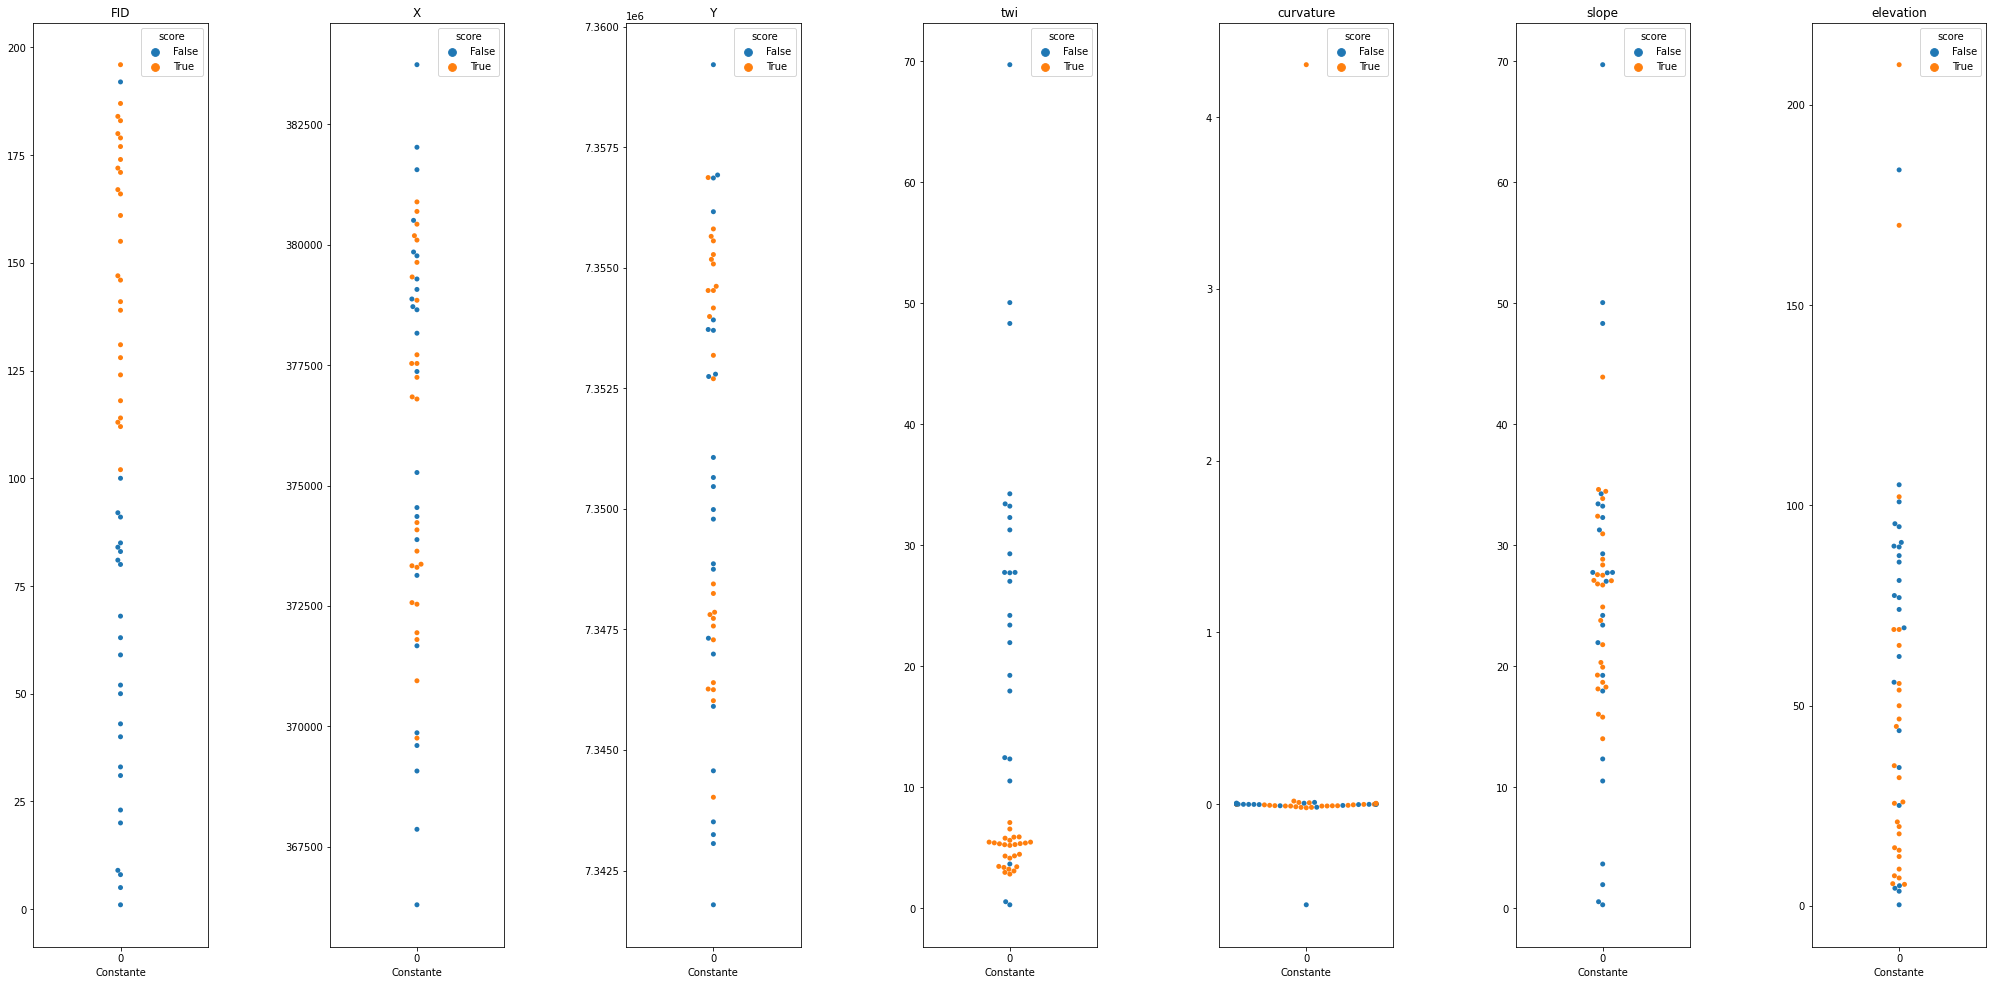

In [77]:
dataSet = output_proprietario.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [78]:
# perguntar para Ale como retornar os dados para ela, se em um csv com cada posição e as respectivas probabilidades?
# se for, basta incorporar essa variável y_pred à uma nova coluna do dataframe

In [79]:
end = datetime.datetime.now()
print(end-start)
quit()

1:08:11.443892


### Keras neural network
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/


Agora, configura a rede com os melhores parâmetros

In [80]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [81]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [ ]:
#{'num_hidden_layers': 1, 'num_units': 4, 'dropout_rate': 0.5, 'learning_rate': 0.004682800657889146}       

In [ ]:
#HyperParameters: {'num_hidden_layers': 2, 'num_units': 12, 'dropout_rate': 0.2821478566400208, 'learning_rate': 0.006549533067877217}
#conjunto de hyperparametros para o Guaruja 87% acuracia dados de teste.

In [ ]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(24, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(24, activation='relu'))
hypermodel.add(Dropout(0.43719886068153724))

#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))

hypermodel.add(Dense(1, activation='sigmoid'))
learning_rate= 0.01
myOptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
hypermodel.compile(optimizer=myOptimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

In [ ]:
print('Best epoch: %d' % (best_epoch,))

In [ ]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

In [ ]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
import tensorflow as tf
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

In [ ]:
if accuracy >= .80:
    print('ótima acurácia, rede salva!')
    hypermodel.save('bestANN\suscetibilidadeKeras_guaruja.pkl')
else:
    print('acurácia abaixo de .85')

#### Assessment

In [ ]:
#X = dataset.drop('class',axis=1)
#y = dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#X = minmax.fit_transform(X.astype(np.float64))
#print(X.min(axis=0), X.max(axis=0))

In [ ]:
#X

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits de X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print('novo dataset')
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

In [ ]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

In [ ]:
y_pred = hypermodel.predict(X_test)
#print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

In [ ]:
output_keras = None
output_keras = dataset_original
output_keras['score'] = y_pred
output_keras.to_csv('bestANN/mapaSuscetibilidade_keras.csv', encoding="utf-8")
output_keras

In [ ]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

In [ ]:
dataSet = output_keras.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [ ]:
end = datetime.datetime.now()
print(end-start)

## References
- ref.1: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref.2: https://www.tensorflow.org/tutorials/structured_data/feature_columns
- ref.3: https://realpython.com/train-test-split-python-data/
- ref.4: https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref.5: https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref.6: https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref.7: https://www.section.io/engineering-education/data-leakage/
- ref.8: https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1
- ref.9: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/